<a href="https://colab.research.google.com/github/JanMeow/T3PyTorchFacadeSegmentaion/blob/main/T3_0807_SAM_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class SamAutomaticMaskGenerator implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

##0.  Environment Set-up



In [1]:
##0.  Environment Set-up
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg


!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-5t7z0ef1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-5t7z0ef1
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=42377a06789b9f789b335e959df381df98a0df42c67b2a9efe24607f851b3c38
  Stored in directory: /tmp/pip-ephem-wheel-cache-dxxdld7r/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-07-10 07:51:47--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

In [2]:
#importing facade images

!wget -O facade.jpg  https://www.architectureartdesigns.com/wp-content/uploads/2020/05/front-11-630x882.jpg
!mv facade.jpg /content/images

--2023-07-10 07:51:58--  https://www.architectureartdesigns.com/wp-content/uploads/2020/05/front-11-630x882.jpg
Resolving www.architectureartdesigns.com (www.architectureartdesigns.com)... 104.26.4.233, 172.67.71.224, 104.26.5.233, ...
Connecting to www.architectureartdesigns.com (www.architectureartdesigns.com)|104.26.4.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘facade.jpg’

facade.jpg              [ <=>                ]  79.48K   515KB/s    in 0.2s    

2023-07-10 07:51:58 (515 KB/s) - ‘facade.jpg’ saved [81390]



##1. Set up

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [5]:
image = cv2.imread('images/facade.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

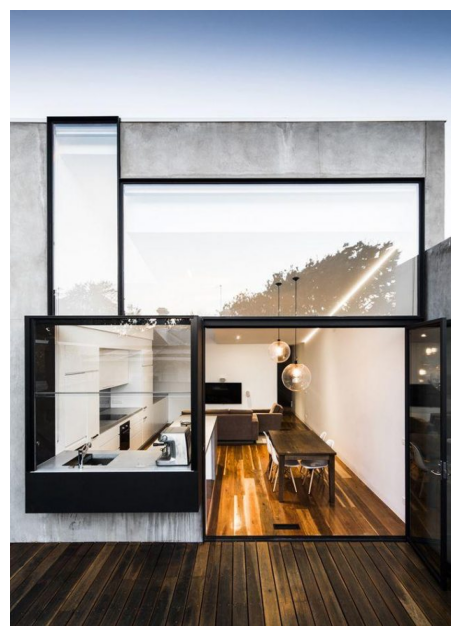

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(image)
plt.axis('off')

plt.show()

##2. Automatic Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [7]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run generate on an image

In [8]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [9]:
print(len(masks))
print(masks[0].keys())

51
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


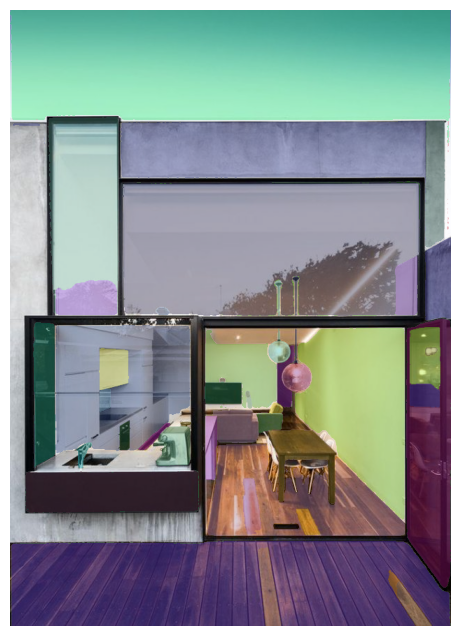

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [11]:
image = cv2.imread('images/facade.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

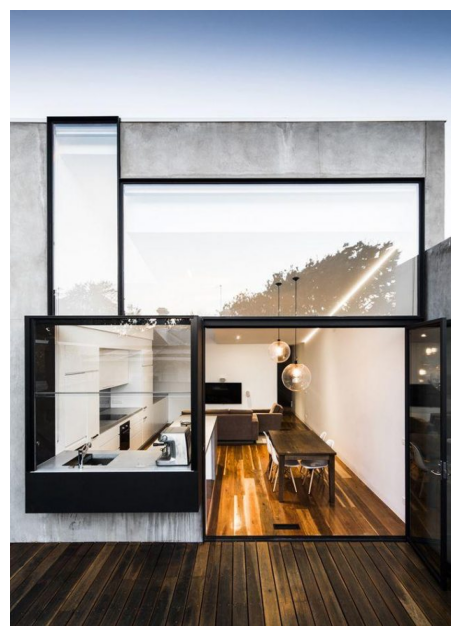

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(image)
plt.axis('off')
plt.show()

In [13]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=10,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [14]:
masks2 = mask_generator_2.generate(image)

In [15]:
len(masks2)

34

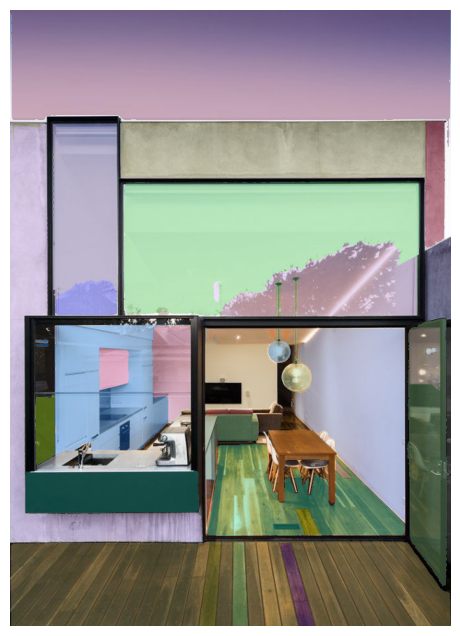

In [16]:
plt.figure(figsize=(8,8))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

#3. Selecting Object with SAM and prompt

In [17]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [18]:
#importing facade images

!wget -O facade1.jpg  https://roundhouses.files.wordpress.com/2013/10/dream-downtown-hotel-nyc1.jpg
!mv facade1.jpg /content/images

--2023-07-10 07:52:44--  https://roundhouses.files.wordpress.com/2013/10/dream-downtown-hotel-nyc1.jpg
Resolving roundhouses.files.wordpress.com (roundhouses.files.wordpress.com)... 192.0.72.28, 192.0.72.29
Connecting to roundhouses.files.wordpress.com (roundhouses.files.wordpress.com)|192.0.72.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 389559 (380K) [image/jpeg]
Saving to: ‘facade1.jpg’

facade1.jpg         100%[===================>] 380.43K  --.-KB/s    in 0.1s    

2023-07-10 07:52:44 (3.36 MB/s) - ‘facade1.jpg’ saved [389559/389559]



In [19]:
image1 = cv2.imread('images/facade1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

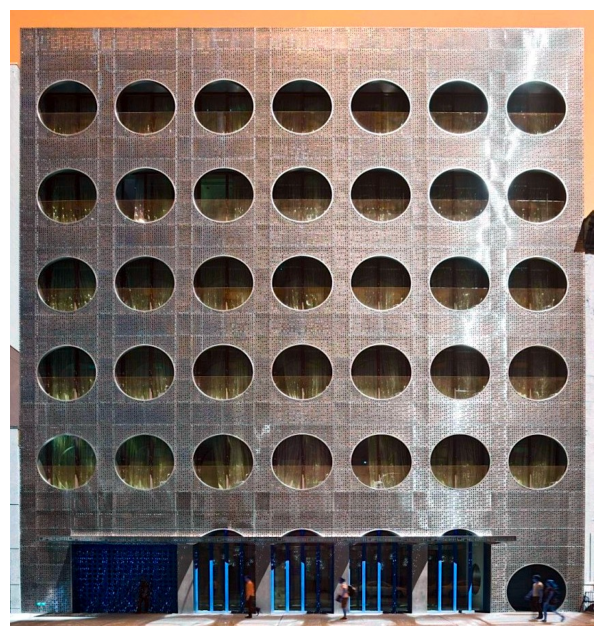

In [20]:
plt.figure(figsize=(8,8))
plt.imshow(image1)
plt.axis('off')
plt.show()

In [21]:
predictor.set_image(image1)

In [22]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

#Specifying an Object with point

In [23]:
input_point = np.array([[310, 395]])
input_label = np.array([1])

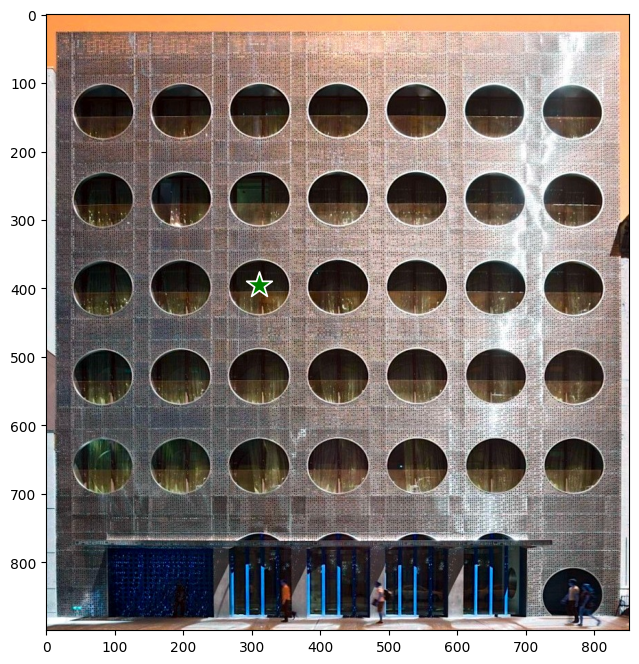

In [24]:
plt.figure(figsize=(8,8))
plt.imshow(image1)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [25]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [26]:
masks.shape

(3, 900, 852)

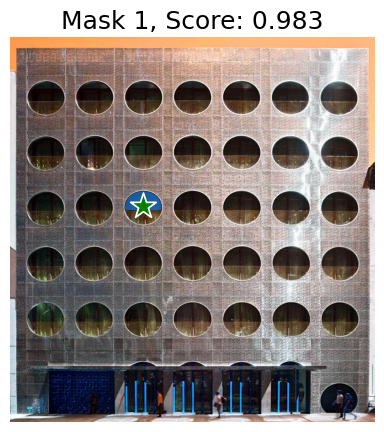

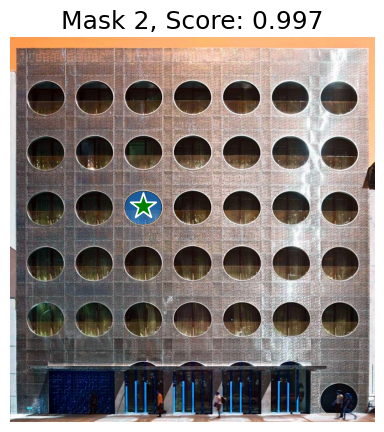

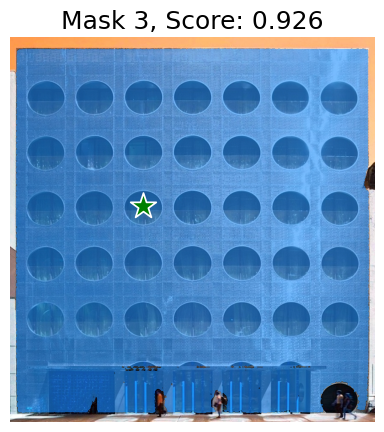

In [27]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(5,5))
    plt.imshow(image1)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

#Specifying a specific object with a box

In [28]:
#input_box format is in x1y1 x2y2
input_box = np.array([240, 210, 500, 300])

In [29]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

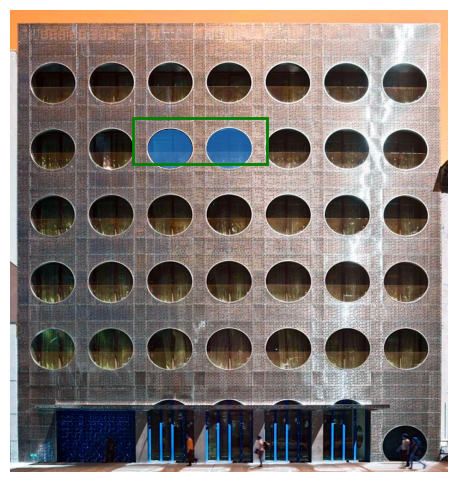

In [30]:
plt.figure(figsize=(6, 6))
plt.imshow(image1)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

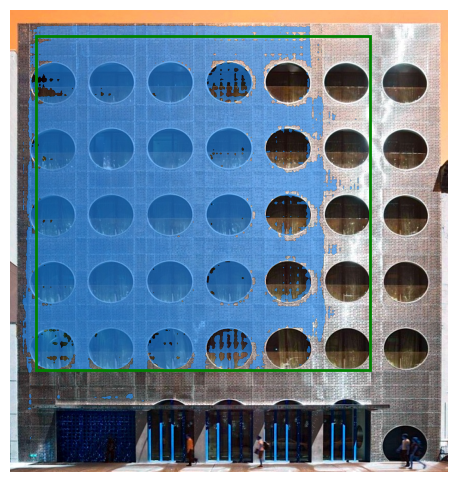

In [31]:
#input_box format is in x1y1 x2y2
input_box = np.array([50, 50, 700, 700])

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(6, 6))
plt.imshow(image1)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

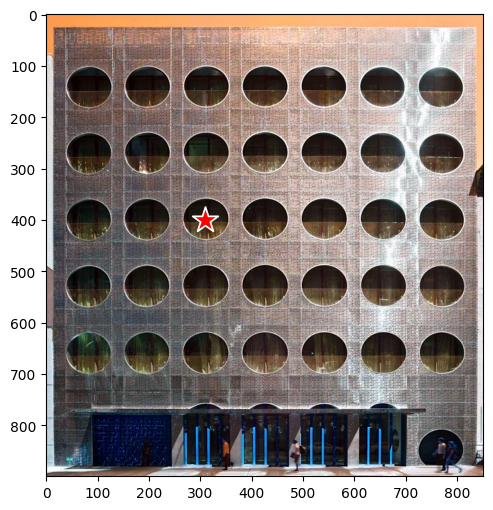

In [32]:
input_point = np.array([[310, 400]])
input_label = np.array([0])

plt.figure(figsize=(6,6))
plt.imshow(image1)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

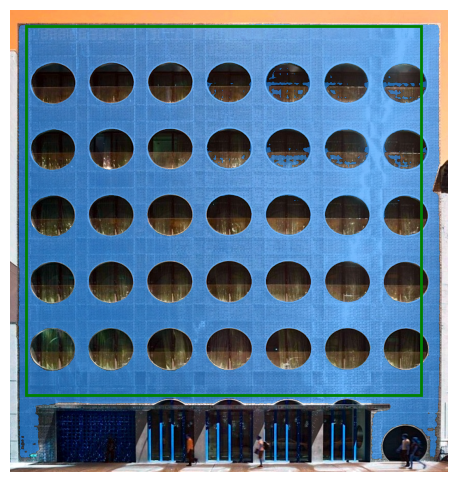

In [33]:
input_point = np.array([[310, 400]])
input_label = np.array([0])

#input_box format is in x1y1 x2y2
input_box = np.array([30, 30, 800, 750])

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(6, 6))
plt.imshow(image1)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()